In [1]:
# Load necessary libraries
import os, random
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller    # For ADF test
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras                      # TensorFlow does not support Python 3.12 yet (as of June 2025)
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
## Algorithm 1 & 2: Data Preparation and Quarterly Aggregation of Variables

# 1. Load the master dataset
df = pd.read_csv('master_Germany.csv')

# 2. Parse the DATE column and create a quarter identifier
df['DATE'] = pd.to_datetime(df['DATE'])
df = df[df['DATE'] <= '2023-12-31']      # to match timeframe wihin dataset
df['quarter'] = df['DATE'].dt.to_period('Q')

# 3. Specify the target variable name
Y_col = 'Real GDP' 

# 5. Identify explanatory variables (exclude DATE, quarter, and Y column)
exclude_cols = {'DATE', 'quarter', Y_col}
x_cols = [col for col in df.columns if col not in exclude_cols]

# 6. Run ADF test for each explanatory variable
adf_results = pd.DataFrame(columns=["Variable", "ADF Statistic", "p-value", "Stationary at 5%"])
X_prime_m_df = df[['DATE', 'quarter']].copy()  # To store transformed monthly variables

for col in x_cols:
    series_original = df[col].copy()
    series_numeric = pd.to_numeric(series_original, errors='coerce').dropna()

    if not series_numeric.empty:
        result = adfuller(series_numeric)
        adf_stat = result[0]
        p_value = result[1]
        is_stationary = p_value < 0.05
        adf_results.loc[len(adf_results)] = [col, adf_stat, p_value, is_stationary]
    else:
        adf_results.loc[len(adf_results)] = [col, np.nan, np.nan, False]

# Display ADF test results
adf_results_display = adf_results.set_index("Variable").sort_values("p-value")
print("\n=== ADF Test Results ===")
print(adf_results_display)



=== ADF Test Results ===
                ADF Statistic       p-value  Stationary at 5%
Variable                                                     
Manuf              -17.068727  7.852860e-30              True
Eff_Ex_Rate         -2.342140  1.587367e-01             False
Uncertainty         -2.266421  1.830267e-01             False
price_comp          -2.135668  2.304164e-01             False
Prod_Vol            -1.517212  5.249802e-01             False
Unemp               -1.214271  6.674269e-01             False
Total Reserves      -0.999402  7.534824e-01             False
Imports             -0.442117  9.028258e-01             False
Exports             -0.320798  9.225067e-01             False
Retail              -0.110208  9.484123e-01             False
^GDAXI              -0.078494  9.515389e-01             False
CPI                  1.164116  9.957283e-01             False


In [3]:
# 7. Manually specify which X columns should be log-differenced
log_diff_cols = [
'Eff_Ex_Rate',              
'Uncertainty',            
'price_comp',           
'Prod_Vol',            
'Unemp',            
'Total Reserves',                
'Imports',        
'Exports',               
'Retail',            
'^GDAXI',                      
'CPI'
]

# 8. Identify explanatory variables that are not log-differenced
non_log_cols = [col for col in x_cols if col not in log_diff_cols]

# 9. Apply transformation to create X_prime_m_df (transformed monthly X)
for col in x_cols:
    if col in log_diff_cols:
        if (df[col] <= 0).any():
            print(f"Warning: Column {col} contains non-positive values. Applying log.diff() may result in NaNs or errors.")
            try:
                X_prime_m_df[col] = np.log(df[col].replace(0, np.nan)).diff()
            except Exception as e:
                print(f"Error log-differencing {col}: {e}. Column will be NaN.")
                X_prime_m_df[col] = np.nan
        else:
            X_prime_m_df[col] = np.log(df[col]).diff()
    else:
        X_prime_m_df[col] = df[col].copy()


# 10. Group the transformed monthly X by quarter
quarter_groups_X_prime = X_prime_m_df.groupby('quarter')

# 11. For log-differenced variables, take the quarterly sum
x_q_aggregated_log = quarter_groups_X_prime[log_diff_cols].sum() if log_diff_cols else pd.DataFrame(index=quarter_groups_X_prime.size().index)

# 12. For non-log-differenced variables, take the quarterly mean
x_q_aggregated_nonlog = quarter_groups_X_prime[non_log_cols].mean() if non_log_cols else pd.DataFrame(index=quarter_groups_X_prime.size().index)

# 13. Combine aggregated quarterly explanatory variables
X_q_aggregated = pd.concat([x_q_aggregated_log, x_q_aggregated_nonlog], axis=1).sort_index()

# 14. Extract quarterly target observations (use the first month of each quarter)
y_q_levels_df = (
    df[df[Y_col].notna()][['quarter', Y_col]]
    .drop_duplicates(subset='quarter', keep='first')    # Ensure we take the first month of each quarter
    .set_index('quarter')
    .sort_index()
)

# 15. Align aggregated X with quarterly Y
common_index = X_q_aggregated.index.intersection(y_q_levels_df.index)
X_q_aligned = X_q_aggregated.loc[common_index]
Y_q_levels = y_q_levels_df.loc[common_index, Y_col]

# 16. Convert Y to quarterly log difference (growth rate)
Y_q_processed = np.log(Y_q_levels).diff().dropna()

# 17. Align X again with the log-differenced Y (drops one more quarter)
X_q_processed = X_q_aligned.loc[Y_q_processed.index]

# Display
print("\n--- Final Processed Data (Before Train/Test Split, No scaling for non-log) ---")
print("Processed Quarterly X shape:", X_q_processed.shape)
print("Processed Quarterly Y shape:", Y_q_processed.shape)
print("\nX_q_processed (first few rows):")
print(X_q_processed.head())
print("\nY_q_processed (first few rows):")
print(Y_q_processed.head())


--- Final Processed Data (Before Train/Test Split, No scaling for non-log) ---
Processed Quarterly X shape: (131, 12)
Processed Quarterly Y shape: (131,)

X_q_processed (first few rows):
         Eff_Ex_Rate  Uncertainty  price_comp  Prod_Vol     Unemp  \
quarter                                                             
1991Q2     -0.025387     0.149049   -0.023872  0.018495  0.018692   
1991Q3      0.012673    -0.669666    0.019761 -0.048267  0.054067   
1991Q4      0.035626     0.298644    0.019378  0.027102  0.051293   
1992Q1     -0.008396    -0.408125   -0.010152  0.000000  0.032790   
1992Q2      0.007229     0.699304    0.006104 -0.024358  0.047253   

         Total Reserves   Imports   Exports    Retail    ^GDAXI       CPI  \
quarter                                                                     
1991Q2        -0.024526  0.023401 -0.036902  0.009266  0.091031  0.012978   
1991Q3         0.059451  0.011141  0.030904 -0.052872 -0.037463  0.011396   
1991Q4         0.028

In [4]:
## Algorithm 3: Neural Network Hyperparameter Optimization

# Set Seed for Reproducibility
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 1. Split the data into training and test sets (80/20 split)
split_idx = int(len(X_q_processed) * 0.8)
X_q_train = X_q_processed.iloc[:split_idx]
Y_q_train = Y_q_processed.iloc[:split_idx]
X_q_test = X_q_processed.iloc[split_idx:]
Y_q_test = Y_q_processed.iloc[split_idx:]

# 2. Standardize non-log-differenced columns
scaler = StandardScaler()    # Z-score
X_q_train_scaled = X_q_train.copy()
X_q_test_scaled = X_q_test.copy()
if non_log_cols:
    X_q_train_scaled[non_log_cols] = scaler.fit_transform(X_q_train[non_log_cols])  # For training data, fit the scaler
    X_q_test_scaled[non_log_cols] = scaler.transform(X_q_test[non_log_cols])        # For test data, we do not fit again, just transform to avid data leakage

# Sign accuracy funtion
def sign_acc_metric(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.sign(y_true), tf.sign(y_pred)), tf.float32))

# 3. KerasTuner funtion
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_q_train_scaled.shape[1],)))
    for i in range(hp.Int('num_layers', 1, 7)):  # up to 5 layers (may increase for more complexity)
        model.add(
            keras.layers.Dense(
                units=hp.Int(f'units_{i}', min_value=8, max_value=700, step=10),
                activation=hp.Choice('activation', ['relu', 'tanh', 'elu', 'selu', 'swish'])
            )
        )
        model.add(
            keras.layers.Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.05)
            )
        )
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(         # Adam optimizer
            learning_rate=hp.Choice('lr', [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
        ),
        loss='mse',
        metrics=['mse', sign_acc_metric]
    )
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_mse',
    max_trials=350,                              # Increase trials for better search
    executions_per_trial=1,
    overwrite=True,
    directory='keras_tuner_dir',
    project_name='gdp_q_nn_wide'
)

tuner.search(
    X_q_train_scaled.values, Y_q_train.values,
    epochs=2000,
    batch_size=4,
    validation_data=(X_q_test_scaled.values, Y_q_test.values),
    callbacks=[keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)],
    verbose=2
)

# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("\n[Best Hyperparameters]")
for k,v in best_hp.values.items():
    print(f"{k}: {v}")

Trial 350 Complete [00h 01m 05s]
val_mse: 0.00043042635661549866

Best val_mse So Far: 0.00031986343674361706
Total elapsed time: 04h 47m 39s

[Best Hyperparameters]
num_layers: 6
units_0: 198
activation: elu
dropout_0: 0.15000000000000002
lr: 0.01
units_1: 538
dropout_1: 0.30000000000000004
units_2: 148
dropout_2: 0.15000000000000002
units_3: 538
dropout_3: 0.1
units_4: 568
dropout_4: 0.15000000000000002
units_5: 328
dropout_5: 0.15000000000000002
units_6: 218
dropout_6: 0.05


/Users/yonggeun/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


2025-06-11 22:58:37.365738: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-11 22:58:37.366978: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


[Model Evaluation on Test Set]
Test MSE: 0.000320
Test RMSE: 0.017885
Test MAE: 0.011116
Test R²: 0.507
Sign Accuracy: 66.67%
sMAPE: 120.11%
Theil's U1: 0.425

'test_MLP_UK.csv' saved.
'test_MLP_DE_summary_metrics.csv' saved.


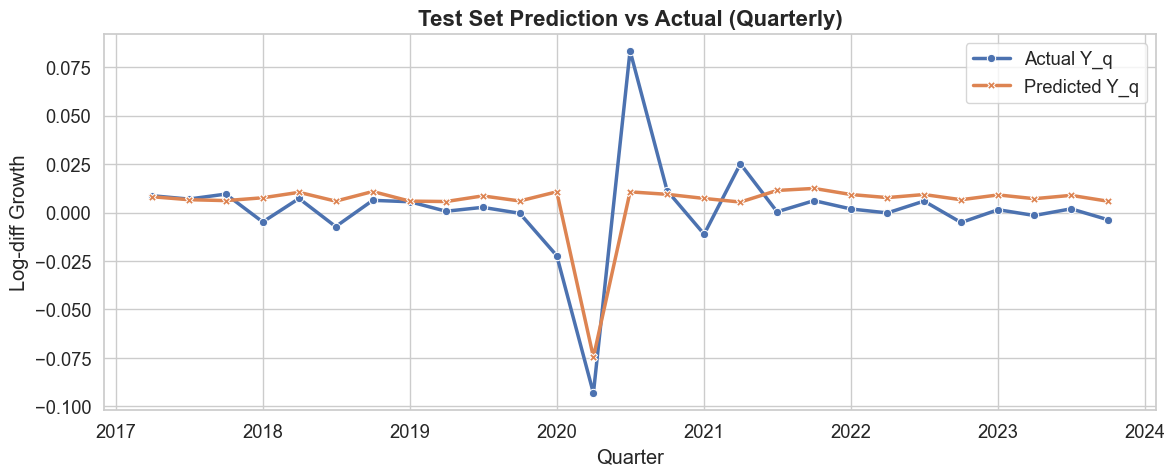

In [5]:
# 5. Quarterly Prediction and Evaluation
y_test_pred = best_model.predict(X_q_test_scaled.values).flatten()

# Define functions for sMAPE and Theil's U1
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    numerator = 2 * np.abs(y_pred - y_true)
    denominator = np.abs(y_true) + np.abs(y_pred)
    ratio = np.divide(numerator, denominator, out=np.zeros_like(numerator, dtype=float), where=denominator!=0)
    return np.mean(ratio) * 100

def theil_u1(y_true, y_pred):
    """Theil's U1 statistic for forecast accuracy"""
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    rms_actual = np.sqrt(np.mean(y_true**2))
    rms_pred = np.sqrt(np.mean(y_pred**2))
    if (rms_actual + rms_pred) == 0:
        return np.nan
    return rmse / (rms_actual + rms_pred)

# Calculate all metrics
mse = mean_squared_error(Y_q_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_q_test, y_test_pred)
r2 = r2_score(Y_q_test, y_test_pred)
sign_acc = (np.sign(y_test_pred) == np.sign(Y_q_test)).mean()
smape_val = smape(Y_q_test, y_test_pred)
theil_u1_val = theil_u1(Y_q_test, y_test_pred)

# Print all metrics
print("\n[Model Evaluation on Test Set]")
print(f"Test MSE: {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test R²: {r2:.3f}")
print(f"Sign Accuracy: {sign_acc:.2%}")
print(f"sMAPE: {smape_val:.2f}%")
print(f"Theil's U1: {theil_u1_val:.3f}")


# Create a DataFrame for per-prediction results
results_index = Y_q_test.index
results_df = pd.DataFrame({
    "Quarter": results_index.to_timestamp(),
    "Actual_Y_q": Y_q_test,
    "Predicted_Y_q": y_test_pred,
    "Sign_Match": (np.sign(y_test_pred) == np.sign(Y_q_test)).astype(int)
})
results_df.to_csv("test_MLP_DE.csv", index=False)
print("\n'test_MLP_UK.csv' saved.")

# Create and save a DataFrame for the summary metrics
metrics_summary_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2', 'Sign Accuracy', 'sMAPE', 'Theil U1'],
    'Value': [mse, rmse, mae, r2, sign_acc, smape_val, theil_u1_val]
})
metrics_summary_df.to_csv("test_MLP_DE_summary_metrics.csv", index=False)
print("'test_MLP_DE_summary_metrics.csv' saved.")

# Plotting
sns.set_theme(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.figure(figsize=(12, 5))
sns.lineplot(x=Y_q_test.index.to_timestamp(), y=Y_q_test.values, label="Actual Y_q", marker="o")
sns.lineplot(x=Y_q_test.index.to_timestamp(), y=y_test_pred, label="Predicted Y_q", marker="X")

plt.title("Test Set Prediction vs Actual (Quarterly)", fontsize=16, weight='bold')
plt.xlabel("Quarter")
plt.ylabel("Log-diff Growth")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# 6. Monthly GDP prediction with reconciliation (Proportional Denton)

# Monthly X scaling (matching columns and order used in model training)
X_m_scaled = X_prime_m_df[X_q_train.columns].copy()
if non_log_cols:
    X_m_scaled[non_log_cols] = scaler.transform(X_m_scaled[non_log_cols])

# Monthly "quarterly-perspective" growth prediction
monthly_y_pred_nn = best_model.predict(X_m_scaled.values).flatten()
monthly_predictions_df = pd.DataFrame({
    'raw_quarterly_log_diff_pred': monthly_y_pred_nn
}, index=X_prime_m_df['DATE'])
monthly_predictions_df.index = pd.to_datetime(monthly_predictions_df.index)
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')

# Naive monthly growth: simply distribute predicted quarterly growth equally to each month
monthly_predictions_df['naive_monthly_log_diff'] = monthly_predictions_df['raw_quarterly_log_diff_pred'] / 3.0

# Actual observed quarterly log growth (Y_q_processed)
actual_quarterly_log_diffs = Y_q_processed.copy()
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')

# For each quarter, calculate scaling factor so the sum of naive monthly growths matches actual quarterly growth
quarterly_sum_of_naive = monthly_predictions_df.groupby('quarter')['naive_monthly_log_diff'].sum()
adjusted_monthly_log_diffs = pd.Series(index=monthly_predictions_df.index, dtype=float)

for quarter, group in monthly_predictions_df.groupby('quarter'):
    if quarter in actual_quarterly_log_diffs.index and quarter in quarterly_sum_of_naive.index:
        actual_q_log_diff = actual_quarterly_log_diffs.loc[quarter]
        sum_naive = quarterly_sum_of_naive.loc[quarter]
        if sum_naive != 0:
            adjustment_factor = actual_q_log_diff / sum_naive
            adjusted_monthly_log_diffs.loc[group.index] = group['naive_monthly_log_diff'] * adjustment_factor
        else:
            # If sum_naive is zero, evenly distribute actual growth across the months in the quarter
            adjusted_monthly_log_diffs.loc[group.index] = actual_q_log_diff / len(group)
    else:
        # If we have no actual value, just use the naive value
        adjusted_monthly_log_diffs.loc[group.index] = group['naive_monthly_log_diff']

monthly_predictions_df['adjusted_monthly_log_diff'] = adjusted_monthly_log_diffs

# Export predicted monthly GDP growth as CSV
mgdp_pred_df = pd.DataFrame({
    "MGDP_logdiff_pred": monthly_predictions_df['adjusted_monthly_log_diff']
}, index=monthly_predictions_df.index)
mgdp_pred_df.index.name = "DATE"
mgdp_pred_df.to_csv("DE_monthly_GDP_MLP_growth.csv")
print("DE_monthly_GDP_MLP_growth.csv saved")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


2025-06-11 22:58:43.707292: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-11 22:58:43.707749: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

DE_monthly_GDP_MLP_growth.csv saved


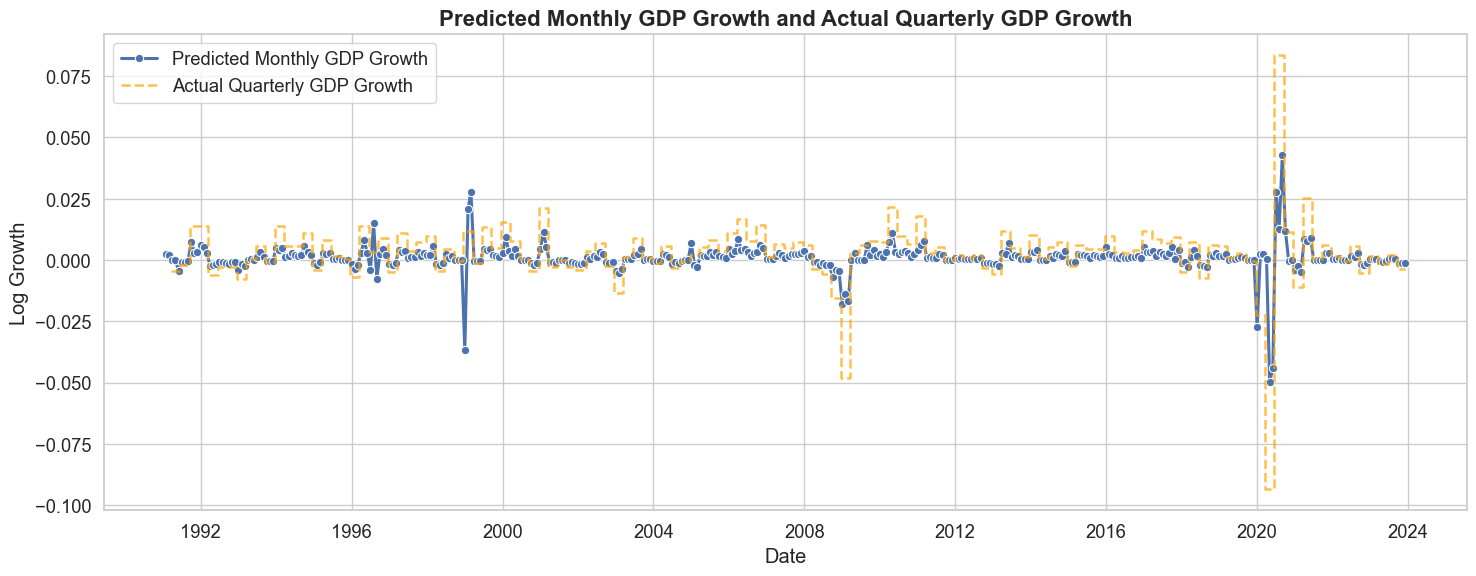

In [7]:
# Plotting Predicted Monthly GDP Growth vs Actual Quarterly GDP Growth
monthly_pred = monthly_predictions_df['adjusted_monthly_log_diff']
quarter_to_growth = actual_quarterly_log_diffs
monthly_actual = monthly_predictions_df['quarter'].map(quarter_to_growth)

sns.set_theme(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(15, 6))
sns.lineplot(x=monthly_pred.index, y=monthly_pred.values, label="Predicted Monthly GDP Growth", marker='o', linewidth=2.2)
plt.step(monthly_actual.index, monthly_actual.values, label="Actual Quarterly GDP Growth",
         where='mid', linestyle='--', color='orange', linewidth=1.8, alpha=0.7)

plt.title("Predicted Monthly GDP Growth and Actual Quarterly GDP Growth", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Log Growth")
plt.legend()
plt.tight_layout()
plt.show()

Base quarter not found. Using the first available GDP level 1991Q1: 517733.8
Final quarterly comparison results:
            Actual_Quarterly_Level  ReAgg_Monthly_Level
quarter                                                
1991-01-01                517733.8        517733.800000
1991-04-01                515466.2        518846.181382
1991-07-01                514515.3        516239.969206
1991-10-01                521756.9        519500.305037
1992-01-01                529126.3        525970.417375

R²: 0.9900, MSE: 64053206.71


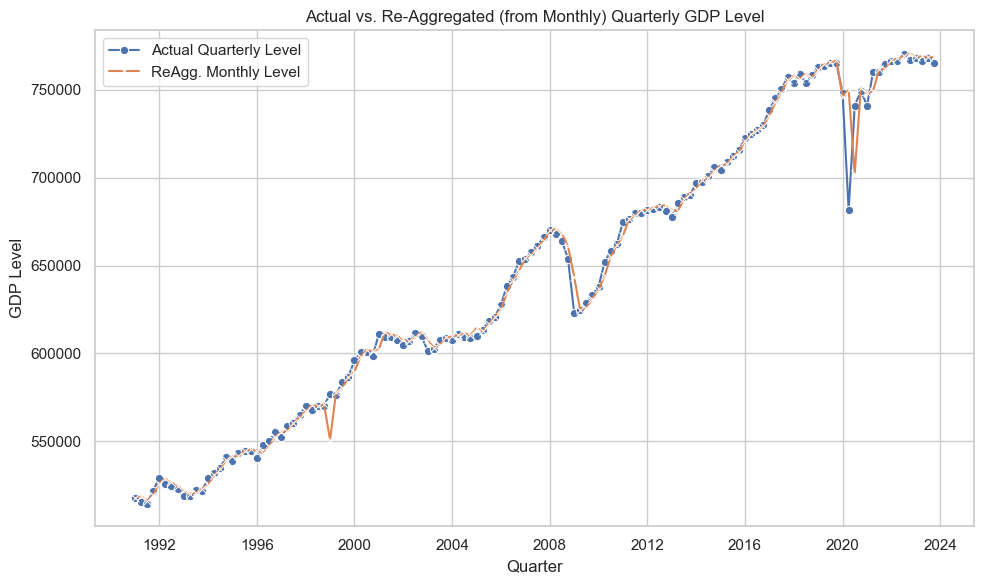

DE_monthly_GDP_MLP_growth_level.csv saved!


In [8]:
# 7. Recover Monthly Level

# Find the first valid index (start month) for growth reconstruction
first_valid_month_idx = monthly_predictions_df['adjusted_monthly_log_diff'].first_valid_index()
first_quarter = monthly_predictions_df.loc[first_valid_month_idx, 'quarter']
base_level_quarter = first_quarter - 1

# Set base_level as the previous quarter's GDP level
if base_level_quarter in Y_q_levels.index:
    base_level = Y_q_levels.loc[base_level_quarter]
    print(f"Using GDP level of base quarter {base_level_quarter} as base_level: {base_level}")
else:
    base_level = Y_q_levels.iloc[0]
    print(f"Base quarter not found. Using the first available GDP level {Y_q_levels.index[0]}: {base_level}")

# Recover monthly GDP levels from growth (starting from the first valid growth)
reconstructed_levels = {}
current_level = base_level
for i, month in enumerate(monthly_predictions_df.index):
    if month < first_valid_month_idx:
        reconstructed_levels[month] = np.nan
    elif month == first_valid_month_idx:
        reconstructed_levels[month] = current_level
    else:
        log_diff = monthly_predictions_df.loc[month, 'adjusted_monthly_log_diff']
        if pd.isna(log_diff):
            reconstructed_levels[month] = np.nan
        else:
            prev_month = monthly_predictions_df.index[monthly_predictions_df.index.get_loc(month) - 1]
            prev_level = reconstructed_levels[prev_month]
            if pd.isna(prev_level):
                reconstructed_levels[month] = np.nan
            else:
                reconstructed_levels[month] = prev_level * np.exp(log_diff)
monthly_predictions_df['reconstructed_monthly_level'] = pd.Series(reconstructed_levels)


# Aggregate to Quarterly Level & Compare with Actual (using first month of each quarter)
monthly_predictions_df['quarter'] = monthly_predictions_df.index.to_period('Q')
re_agg_quarterly = (
    monthly_predictions_df
    .groupby('quarter')['reconstructed_monthly_level']
    .first()
)

# Convert index to Timestamp for plotting
re_agg_quarterly_ts = re_agg_quarterly.copy()
re_agg_quarterly_ts.index = re_agg_quarterly_ts.index.to_timestamp(how='start')
Y_q_levels_ts = Y_q_levels.copy()
Y_q_levels_ts.index = Y_q_levels_ts.index.to_timestamp(how='start')

comparison_df = pd.DataFrame({
    'Actual_Quarterly_Level': Y_q_levels_ts,
    'ReAgg_Monthly_Level': re_agg_quarterly_ts
}).dropna()

print("Final quarterly comparison results:")
print(comparison_df.head())
print("\nR²: %.4f, MSE: %.2f" % (
    r2_score(comparison_df['Actual_Quarterly_Level'], comparison_df['ReAgg_Monthly_Level']),
    mean_squared_error(comparison_df['Actual_Quarterly_Level'], comparison_df['ReAgg_Monthly_Level'])
))


# Plot 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(x=comparison_df.index, y=comparison_df['Actual_Quarterly_Level'], marker='o', label='Actual Quarterly Level')
sns.lineplot(x=comparison_df.index, y=comparison_df['ReAgg_Monthly_Level'], marker='x', label='ReAgg. Monthly Level')
plt.title("Actual vs. Re-Aggregated (from Monthly) Quarterly GDP Level")
plt.xlabel("Quarter")
plt.ylabel("GDP Level")
plt.legend()
plt.tight_layout()
plt.show()


# Save monthly GDP growth and level to CSV
out_df = pd.DataFrame({
    "MGDP_logdiff_pred": monthly_predictions_df['adjusted_monthly_log_diff'],
    "MGDP_level_pred": monthly_predictions_df['reconstructed_monthly_level']
}, index=monthly_predictions_df.index)
out_df.index.name = "DATE"
out_df.to_csv("DE_monthly_GDP_MLP_growth_level.csv")
print("DE_monthly_GDP_MLP_growth_level.csv saved!")
